In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv("EDS_1.csv", nrows=10000000)

In [3]:
df

,timestamp,elevator_id,x,y,primary_axis,normalized
0,2018-07-09 12:00:00.030,1,0.015625,-0.050781,0.789063,0.440275
1,2018-07-09 12:00:00.070,1,0.007813,-0.054688,0.789063,0.529937
2,2018-07-09 12:00:00.109,1,0.011719,-0.050781,0.789063,0.652731
3,2018-07-09 12:00:00.148,1,0.015625,-0.058594,0.792969,0.584590
4,2018-07-09 12:00:00.188,1,0.015625,-0.062500,0.789063,0.145139
...,...,...,...,...,...,...
9999995,2018-07-14 01:39:32.887,1,0.015625,-0.054688,0.785156,0.027975
9999996,2018-07-14 01:39:32.926,1,0.011719,-0.054688,0.785156,-0.342538
9999997,2018-07-14 01:39:32.965,1,0.011719,-0.058594,0.777344,-0.523516
9999998,2018-07-14 01:39:33.005,1,0.015625,-0.058594,0.785156,-0.417307


In [4]:

def f(row):
    if row['normalized'] < -0.4307273:
        val = -1
    elif row['normalized'] > 0.4307273:
        val = 1
    else:
        val = 0
    return val

df['sax'] = df.apply(f, axis=1)

df = df[df['sax'] != 0]



In [43]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

def create_dataset(X, y):
    time_steps=1
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)
        ys.append(y.iloc[i + time_steps]) 
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train['normalized'], train.sax)
X_test, y_test = create_dataset(test['normalized'], test.sax)





In [44]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))


In [45]:
print(X_train.shape)

print(y_train.shape)

print(X_test.shape)

print(y_test.shape)

(1840215, 1)
(1840215, 1)
(204468, 1)
(204468, 1)


In [65]:
from sklearn.metrics import mean_squared_error

model = xgb.XGBRegressor(n_estimators=10000, max_depth = 4)

model.fit(X_train, y_train, verbose=False)


X_train_pred = model.predict(X_train)

train_loss = mean_squared_error(X_train, X_train_pred)

X_test_pred = model.predict(X_test)

test_loss = mean_squared_error(X_test,X_test_pred)



KeyboardInterrupt: 

In [47]:

print(train_loss)
print(test_loss)


4.286012682241739
2.735735651028952


In [32]:
'''
x_train_oned = []
for i in range(len(X_train)):
    x_train_oned.append(X_train[i][0])
    
x_test_oned = []
for i in range(len(X_test)):
    x_test_oned.append(X_test[i][0])

x_df = pd.DataFrame({'X_train':X_train, 'X_train_pred':X_train_pred})
y_df = pd.DataFrame({'X_test':X_test, 'X_test_pred':X_test_pred})

_ = x_df[['X_train','X_train_pred']].plot(figsize=(15, 5))

_ = y_df[['X_test', 'X_test_pred']].plot(figsize=(15, 5))
'''

In [63]:
TIME_STEPS = 30
THRESHOLD = 2
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)

test_score_df['loss'] = test_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold


test_score_df['normalized'] = test[TIME_STEPS:].normalized
test_score_df['sax'] = test[TIME_STEPS:].sax

anomalies = test_score_df[test_score_df.anomaly == True]



/Users/archanasubramanian/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


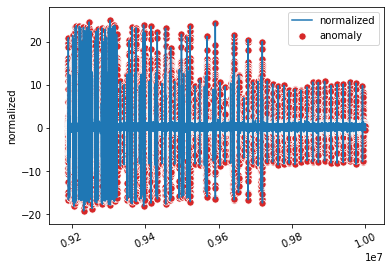

In [64]:
plt.plot(
  test[TIME_STEPS:].index,
  test[TIME_STEPS:].normalized,
  label='normalized'
);

sns.scatterplot(
  anomalies.index,
  anomalies.normalized,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

